##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [1]:
%pip install pandas 
%pip install matplotlib
# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME 

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and 
##### have the .csv file inside that. A relative path *must* be used when loading data into pandas

In [2]:
# Can have as many cells as you want for code
import pandas as pd
df = pd.read_csv('data/catA_train.csv') 
# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file

In [3]:
#print(df.isna().sum())

# removes latitude, longitude as missing data is little
df = df.dropna(subset=["LATITUDE", "LONGITUDE"])

# remove entire square footage data col as no data available, missing data == no.of rows
df = df.drop('Square Footage', axis=1)

#remove entire Fiscal year end col as too less data
df = df.drop("Fiscal Year End", axis=1)

#print(df.isna().sum())

# Remove rows where the Company Status is 'Inactive'
df = df[df['Company Status (Active/Inactive)'] == 'Active']

df['Import/Export Status_Missing'] = df['Import/Export Status'].isna()

df = df.dropna(subset=["Employees (Single Site)", "Employees (Domestic Ultimate Total)", "Employees (Global Ultimate Total)",
                                       "Year Found"])

# to ensure important info isnt being lost
df['Import/Export Status_Missing'] = df['Import/Export Status'].isna()

df = df.dropna(subset=["Employees (Single Site)", "Employees (Domestic Ultimate Total)", "Employees (Global Ultimate Total)",
                                       "Year Found", 'Parent Company', 'Parent Country', 'Global Ultimate Company', 'Global Ultimate Country', 'Domestic Ultimate Company'])

df = pd.get_dummies(df, columns=['Entity Type'], prefix='Entity_Type')
df = pd.get_dummies(df, columns=['Ownership Type'], prefix='Ownership_Type')
df = pd.get_dummies(df, columns=['Import/Export Status'], prefix='Import_Export_Status')
df = df.drop(columns=[col for col in ["Company Status (Active/Inactive)", "Entity Type", 'Import/Export Status', 'Ownership Type'] if col in df.columns], errors='ignore') # are all Active
print(df.isna().sum())


LATITUDE                                       0
LONGITUDE                                      0
AccountID                                      0
Company                                        0
SIC Code                                       0
Industry                                       0
8-Digit SIC Code                               0
8-Digit SIC Description                        0
Year Found                                     0
Parent Company                                 0
Parent Country                                 0
Company Description                            0
Employees (Single Site)                        0
Employees (Domestic Ultimate Total)            0
Employees (Global Ultimate Total)              0
Sales (Domestic Ultimate Total USD)            0
Sales (Global Ultimate Total USD)              0
Global Ultimate Company                        0
Global Ultimate Country                        0
Domestic Ultimate Company                      0
Is Domestic Ultimate

In [4]:
# Find the frequency of each industry
sic_code_frequency = df['SIC Code'].value_counts()

# Set a threshold for low-frequency SIC Codes
threshold = 7 

# Identify SIC Codes with frequency below the threshold
low_frequency_sic_codes = sic_code_frequency[sic_code_frequency < threshold].index

# Replace these low-frequency SIC Codes with a common label "Others"
df['SIC Code'] = df['SIC Code'].replace(low_frequency_sic_codes, 'Others')

sic_code_frequency1 = df['SIC Code'].value_counts()

# Display the updated DataFrame
print(sic_code_frequency1)

SIC Code
6719.0    2626
Others     837
8742.0     618
7389.0     433
4731.0     419
          ... 
3241.0       7
3448.0       7
3826.0       7
5153.0       7
3541.0       7
Name: count, Length: 237, dtype: int64


### **ALL** Code for machine learning and dataset analysis should be entered below. 
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

In [5]:
# convert to str cus we dont want it to be trained as a numeric value
# Convert the entire column to a common data type (string in this case)
df['SIC Code'] = df['SIC Code'].astype(str)

In [6]:
print(df.isna().sum())

LATITUDE                                       0
LONGITUDE                                      0
AccountID                                      0
Company                                        0
SIC Code                                       0
Industry                                       0
8-Digit SIC Code                               0
8-Digit SIC Description                        0
Year Found                                     0
Parent Company                                 0
Parent Country                                 0
Company Description                            0
Employees (Single Site)                        0
Employees (Domestic Ultimate Total)            0
Employees (Global Ultimate Total)              0
Sales (Domestic Ultimate Total USD)            0
Sales (Global Ultimate Total USD)              0
Global Ultimate Company                        0
Global Ultimate Country                        0
Domestic Ultimate Company                      0
Is Domestic Ultimate

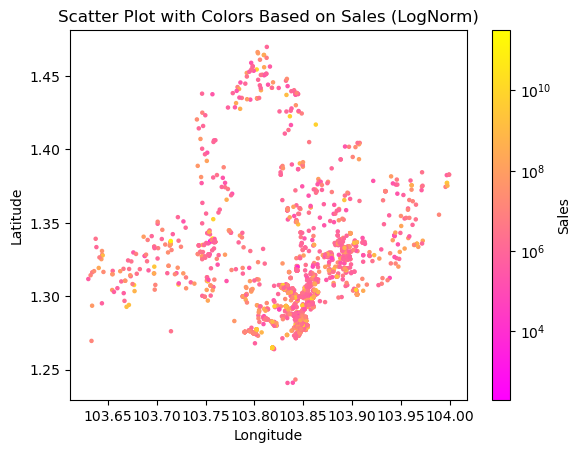

In [9]:
# Use of a correlation matrix to observe how variables in our dataset may be affected by others
numerical_df = df.select_dtypes(include=['float64', 'int64'])

# Create a correlation matrix
correlation_matrix = numerical_df.corr()

# Assuming correlation_matrix is your correlation matrix
correlation_df = pd.DataFrame(correlation_matrix)

# Print or use the correlation DataFrame as needed
correlation_df

# Correlation threshold
threshold = 0.8

# Find highly correlated variables
correlated_variables = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            correlated_variables.add(colname)

# Remove correlated variables            
df3 = df.drop(columns=correlated_variables)

# Feature selection from domain knowledge
columns_to_drop = ["error", "Sales (Global Ultimate Total USD)", "Global Ultimate Company", "Domestic Ultimate Company", "Web Address",
                   "Sales (Global Ultimate Total USD)", "Company Description", "PostCode", "8-Digit SIC Description", "AccountID",
                   "Parent Company", "City", "Country", "Address", "Address1", "Industry", "Region", "Parent Country", "Global Ultimate Country", "Company"]

# Drop columns if they exist in the DataFrame
df4 = df3.drop(columns=[col for col in columns_to_drop if col in df3.columns], errors='ignore')

# Convert 'Is Domestic Ultimate' to True/False
df4['Is Domestic Ultimate'] = df4['Is Domestic Ultimate'] == 1
df4['Is Global Ultimate'] = df4['Is Global Ultimate'] == 1
df4['SIC Code'] = pd.to_numeric(df4['SIC Code'], errors='coerce')

# Import required libraries
import matplotlib.pyplot as plt

# Color gradient
from matplotlib.colors import LogNorm
import seaborn as sns

# Use a small subset of the data for geospatial analysis
filtered_df = df4[df4['SIC Code'].isin([6719, 3083, 5812, 4119])]

norm = LogNorm()
cmap = 'spring'

# Scatter plot with colors based on Sales values and LogNorm
scatter = plt.scatter(filtered_df['LONGITUDE'], filtered_df['LATITUDE'], c=filtered_df['Sales (Domestic Ultimate Total USD)'], cmap=cmap, s=5, norm=norm)

# Add a colorbar
cbar = plt.colorbar(scatter, label='Sales')

# Set labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter Plot with Colors Based on Sales (LogNorm)')

# Show the plot
plt.show()

In [10]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import GradientBoostingRegressor

In [11]:
# Separate features and target variable
X = df4.drop('Sales (Domestic Ultimate Total USD)', axis=1)
y = df4['Sales (Domestic Ultimate Total USD)']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the GradientBoostingRegressor
model = GradientBoostingRegressor(random_state=42)

In [12]:
# Lists to store results
n_folds_values = list(range(4, 16))
mean_r2_scores = []
std_r2_scores = []

# Iterate over different numbers of folds
for n_folds in n_folds_values:
    # Use k-fold cross-validation with the current number of folds
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    # Perform cross-validation and get R-squared scores
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')

    # Append mean and standard deviation of R-squared scores to lists
    mean_r2_scores.append(cv_scores.mean())
    std_r2_scores.append(cv_scores.std())

# Plot the results
plt.errorbar(n_folds_values, mean_r2_scores, yerr=std_r2_scores, marker='o', linestyle='-', label='R-squared scores')
plt.xlabel('Number of Folds')
plt.ylabel('R-squared Score')
plt.title('Cross-Validated R-squared Scores for Different Numbers of Folds')
plt.legend()
plt.show()

ValueError: 
All the 4 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/edenaong/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/edenaong/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/edenaong/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py", line 416, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "/Users/edenaong/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 621, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/edenaong/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1147, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/Users/edenaong/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py", line 959, in check_array
    _assert_all_finite(
  File "/Users/edenaong/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py", line 124, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/Users/edenaong/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py", line 173, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
GradientBoostingRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


In [13]:
# Use k-fold cross-validation with 10 folds
model_10 = GradientBoostingRegressor(random_state=42)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation and get R-squared scores
cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')

# Print the R-squared scores for each fold
print("Cross-Validation R-squared scores:", cv_scores)

# Print the mean and standard deviation of the R-squared scores
print("Mean R-squared score:", cv_scores.mean())
print("Standard Deviation of R-squared scores:", cv_scores.std())

# Train the model on the entire training set
model_10.fit(X_train, y_train)

# Evaluate the model on the test set
test_score = model_10.score(X_test, y_test)
print("Test R-squared score:", test_score)

ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/edenaong/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/edenaong/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/edenaong/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py", line 416, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "/Users/edenaong/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 621, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/edenaong/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1147, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/Users/edenaong/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py", line 959, in check_array
    _assert_all_finite(
  File "/Users/edenaong/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py", line 124, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/Users/edenaong/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py", line 173, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
GradientBoostingRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


In [ ]:
import joblib

# Save the base model to an HDF5 file
joblib.dump(model_10, 'base_model.h5')

In [ ]:
def test_model(data):
    # we assume the data is cleaned
    # To load the model in the future
    loaded_model = joblib.load('./base_model.h5')
    predictions = loaded_model.predict(data)

    return predictions

# Extract the last row of the test set
last_row = X_test.iloc[[1]]

# Make predictions on the last row
print(test_model(last_row))

## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [ ]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform. 
    
All relevant code MUST be included in this function.'''

    result = [] 
    return result

##### Cell to check testing_hidden_data function

In [ ]:
# This cell should output a list of predictions.
test_df = pd.read_csv(filepath)
test_df = test_df.drop(columns=['Sales (Domestic Ultimate Total USD)'])
print(testing_hidden_data(test_df))

### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!